In [ ]:
import torch
import warnings
import numpy as np
import pandas  as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')

In [ ]:
X, y = make_classification(n_samples = 1000, weights = [0.5,0.5], n_clusters_per_class = 1, n_features=2, n_informative=2, n_redundant=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).reshape(y_test.size,1)
X_tensor = torch.FloatTensor(X_train)
y_tensor = torch.FloatTensor(y_train).reshape(y_train.size,1)
train_ds = TensorDataset(X_tensor, y_tensor)
batch_size = int(X_train.shape[0] / 10)
train_dl = DataLoader(train_ds, batch_size)

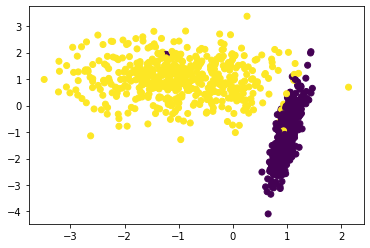

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
def normalize(vec):
    return vec / np.linalg.norm(vec)

def generate_UDV(d):
    u = np.random.normal(size = d)
    return normalize(u)

def generate_UDV_comp_wise(d):
    i = np.random.random_integers(0, d-1)
    u = np.zeros(d)
    u[i] = 1
    return u
    
def stohastic_grad(model, xb, yb, loss_fn, gamma = 1e-2):
    #From Smoothing Scheme
    d = 2
    u = generate_UDV(d)
    u_tens = torch.Tensor([u])
    u_tens.float()
    init = model.weight.data
    
    model.weight.data =  init + (u_tens * gamma) 
    pred = F.sigmoid(model(xb))
    pred_plus = loss_fn(pred, yb)
    
    model.weight.data =  init - (u_tens * gamma)
    pred = F.sigmoid(model(xb))
    pred_minus = loss_fn(pred, yb)
    
    model.weight.data = init
    
    return d * (pred_plus - pred_minus) * u_tens / (2 * gamma)

def stohastic_grad_comp_wise(model, xb, yb, loss_fn, gamma = 1e-2):
    #From Smoothing Scheme
    d = 2
    u = generate_UDV_comp_wise(d)
    u_tens = torch.Tensor([u])
    u_tens.float()
    init = model.weight.data
    
    model.weight.data =  init + (u_tens * gamma) 
    pred = F.sigmoid(model(xb))
    pred_plus = loss_fn(pred, yb)
    
    model.weight.data =  init - (u_tens * gamma)
    pred = F.sigmoid(model(xb))
    pred_minus = loss_fn(pred, yb)
    
    model.weight.data = init
    
    return d * (pred_plus - pred_minus) * u_tens / (2 * gamma)

def two_dot_grad(model, xb, yb, loss_fn, gamma = 1e-2):
    #Shamir 2017
    d = 2
    u = generate_UDV(d)
    u_tens = torch.Tensor([u])
    u_tens.float()
    init = model.weight.data
    
    pred = F.sigmoid(model(xb))
    pred_zero = loss_fn(pred, yb)
    
    model.weight.data =  init + (u_tens * gamma)
    pred = F.sigmoid(model(xb))
    pred_plus = loss_fn(pred, yb)
    
    model.weight.data = init
    
    return d * (pred_plus - pred_zero) * u_tens / (gamma)

def fit(num_epochs, model, loss_fn, optimizer, train_dl, lr = 1e-2):
    # повторяем нужное число эпох
    losses = []
    for epoch in range(num_epochs):
        loss = 0
        model.train() # перенести раньше, если не выходим из режима обучения
        for xb, yb in train_dl: # по батчам
            pred = F.sigmoid(model(xb)) # прогнать прямой ход
            loss = loss_fn(pred, yb) # вычислить ошибку
            with torch.no_grad():
                model.weight -= lr * optimizer(model, xb, yb, loss_fn) # изменить параметры
        losses.append(loss.item())
        if (epoch+1) % 1000 == 0: # прогресс
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    return losses

def model_fun2(x):
    w = model.weight
    b = model.bias
    k = w[0][0].detach().numpy()
    v = w[0][1].detach().numpy()
    b = b[0].detach().numpy()
    return -1*k*x/v - b/v

In [ ]:
#Stohastic
model = nn.Linear(2,1)
model.weight.data = torch.Tensor([[1,1]])
loss_fn = torch.nn.MSELoss()

print("Stohastic grad:")
traj_sgd = []
traj_sgd = fit(3000, model, loss_fn, stohastic_grad, train_dl)

Stohastic grad:
Epoch [1000/3000], Loss: 0.0356
Epoch [2000/3000], Loss: 0.0335
Epoch [3000/3000], Loss: 0.0332


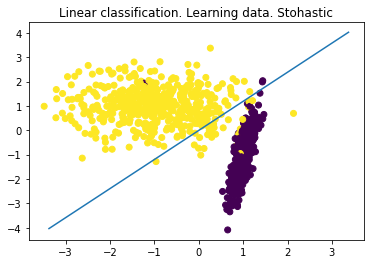

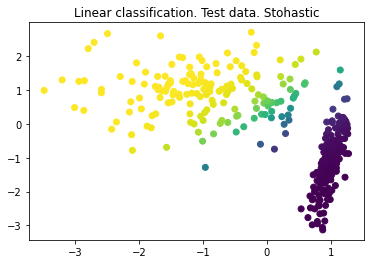

In [ ]:
a = np.max(X[:, 0])
b = np.max(X[:, 1])
c = (max(a, b))
l = np.linspace(-c, c)
plt.plot(l, model_fun2(l))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Linear classification. Learning data. Stohastic")
plt.show()
plt.scatter(X_test_tensor.numpy()[:, 0], X_test_tensor.numpy()[:, 1], c=F.sigmoid(model(X_test_tensor).detach()))
plt.title("Linear classification. Test data. Stohastic")
plt.show()

In [ ]:
#Stohastic COMPWISE
model = nn.Linear(2,1)
model.weight.data = torch.Tensor([[1,1]])
loss_fn = torch.nn.MSELoss()

print("Stohastic grad COMPWISE:")
traj_sgd_cw = []
traj_sgd_cw = fit(3000, model, loss_fn, stohastic_grad_comp_wise, train_dl)

Stohastic grad COMPWISE:
Epoch [1000/3000], Loss: 0.0358
Epoch [2000/3000], Loss: 0.0337
Epoch [3000/3000], Loss: 0.0334


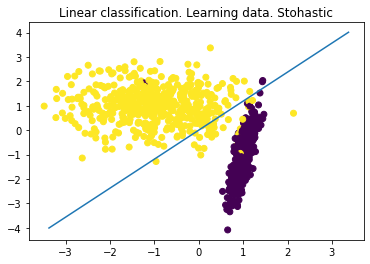

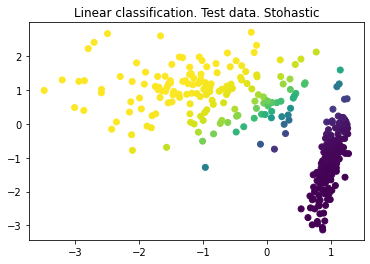

In [ ]:
a = np.max(X[:, 0])
b = np.max(X[:, 1])
c = (max(a, b))
l = np.linspace(-c, c)
plt.plot(l, model_fun2(l))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Linear classification. Learning data. Stohastic")
plt.show()
plt.scatter(X_test_tensor.numpy()[:, 0], X_test_tensor.numpy()[:, 1], c=F.sigmoid(model(X_test_tensor).detach()))
plt.title("Linear classification. Test data. Stohastic")
plt.show()

In [ ]:
#Two dot 1
model = nn.Linear(2,1)
model.weight.data = torch.Tensor([[1,1]])
loss_fn = torch.nn.MSELoss()

print("Two dot grad:")
traj_tdg = []
traj_tdg = fit(3000, model, loss_fn, two_dot_grad, train_dl)

Two dot grad:
Epoch [1000/3000], Loss: 0.0260
Epoch [2000/3000], Loss: 0.0229
Epoch [3000/3000], Loss: 0.0226


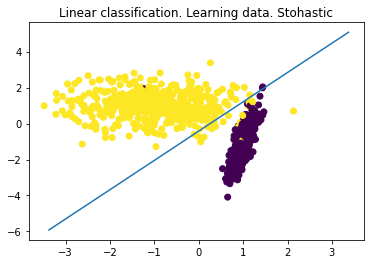

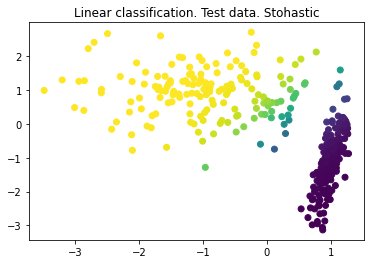

In [ ]:
a = np.max(X[:, 0])
b = np.max(X[:, 1])
c = (max(a, b))
l = np.linspace(-c, c)
plt.plot(l, model_fun2(l))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Linear classification. Learning data. Stohastic")
plt.show()
plt.scatter(X_test_tensor.numpy()[:, 0], X_test_tensor.numpy()[:, 1], c=F.sigmoid(model(X_test_tensor).detach()))
plt.title("Linear classification. Test data. Stohastic")
plt.show()

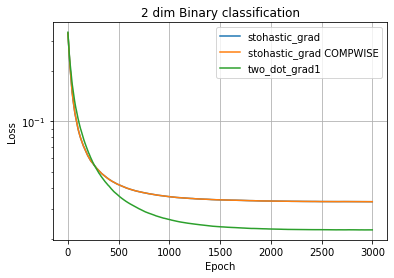

In [ ]:
plt.plot(np.array(range(len(traj_sgd))), traj_sgd, label = "stohastic_grad")
plt.plot(np.array(range(len(traj_sgd_cw))), traj_sgd, label = "stohastic_grad COMPWISE")
plt.plot(np.array(range(len(traj_tdg))), traj_tdg, label = "two_dot_grad1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.title("2 dim Binary classification")
plt.legend()
plt.grid()
plt.show()